In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
import seaborn as sns

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=200, n_features=2,
    n_informative=2, n_redundant=0,
    random_state=42
)


data = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))),
                    columns=['x1', 'x2', 'y'])

__Задание 1.__

Обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделяющую поверхность на трейне (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились? (2б)

In [3]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
print(f"Accuracy on test = {accuracy_score(y_test, clf_tree.predict(X_test))}")
print(f"Accuracy on train = {accuracy_score(y_train, clf_tree.predict(X_train))}")

Accuracy on test = 0.8
Accuracy on train = 1.0


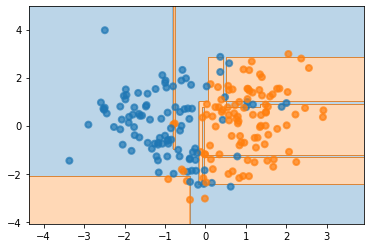

In [8]:
plot_surface(clf_tree, X, y)

__Задание 2.__

Переберите несколько параметров для регуляризации (`max_depth`, `min_samples_leaf`) из предложенных. Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Используйте, если хотите, функцию ниже. Как изменение параметров влияет на поверхность? При каких параметрах на тесте достигается лучшее качество? А на трейне? (2б).

In [11]:
def plot_surface_axes(clf, X, y, ax, train_acc, test_acc):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
    edgecolors=np.array(palette)[y], linewidths=2)
    
    ax.plot([], [], label = 'train_acc : %0.5f' % train_acc)
    ax.plot([], [], label = 'test_acc : %0.5f' % test_acc)
    
    plt.legend(loc = 'lower right', prop={'size': 20})

In [21]:
max_depth_set = [6, 7, 8, 9, 12]

min_samples_leaf_set = [3, 5, 7, 10]

parameters = {'max_depth' : max_depth_set,
          'min_samples_split' : min_samples_leaf_set}

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state = 42) 

In [22]:
from sklearn.model_selection import GridSearchCV

clf_tree = DecisionTreeClassifier()
grid_search_tree = GridSearchCV(clf_tree, parameters)
grid_search_tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [6, 7, 8, 9, 12],
                         'min_samples_split': [3, 5, 7, 10]})

In [23]:
grid_search_tree.best_params_

{'max_depth': 6, 'min_samples_split': 3}

__Задание 3.__

Добавим признак $2\cdot x_1 - x_2$, транформацию добавим как шаг пайплайна. С помощью данного класса (из практики/лекции) обучите дерево с максимальной глубиной=3, нарисуйте поверхность на трейне, посчитайте accuracy (2 б)

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomFunctionTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, first_col, second_col, function):
        self.first_col = first_col
        self.second_col = second_col
        self.function = function
        print("Инициализировали класс!")
        
    def fit(self, X, y=None):
        print("Зафитили датасет!")
        return self
    
    def transform(self, X, y=None):
        
        X_ = X.copy()
        X_['new_feature'] = self.function(X_[self.first_col], X_[self.second_col])
        X_ = X_.drop([self.first_col, self.second_col], axis=1)
        
        print("Трансформировали датасет!")
        return X_

In [25]:
X_train = pd.DataFrame(X_train, columns=['x1', 'x2'])
X_test = pd.DataFrame(X_test, columns=['x1', 'x2'])

In [52]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('CustomTransform', CustomFunctionTransformer('x1', 'x2', lambda x, y: 2*x-y)),
                     ('ClfTree', DecisionTreeClassifier(max_depth=3))])
pipe.fit(X_train, y_train)
print(f"Accuracy on test = {accuracy_score(y_test, pipe.predict(X_test))}")
print(f"Accuracy on train = {accuracy_score(y_train, pipe.predict(X_train))}")

Инициализировали класс!
Зафитили датасет!
Трансформировали датасет!
Трансформировали датасет!
Accuracy on test = 0.75
Трансформировали датасет!
Accuracy on train = 0.8625


Трансформировали датасет!


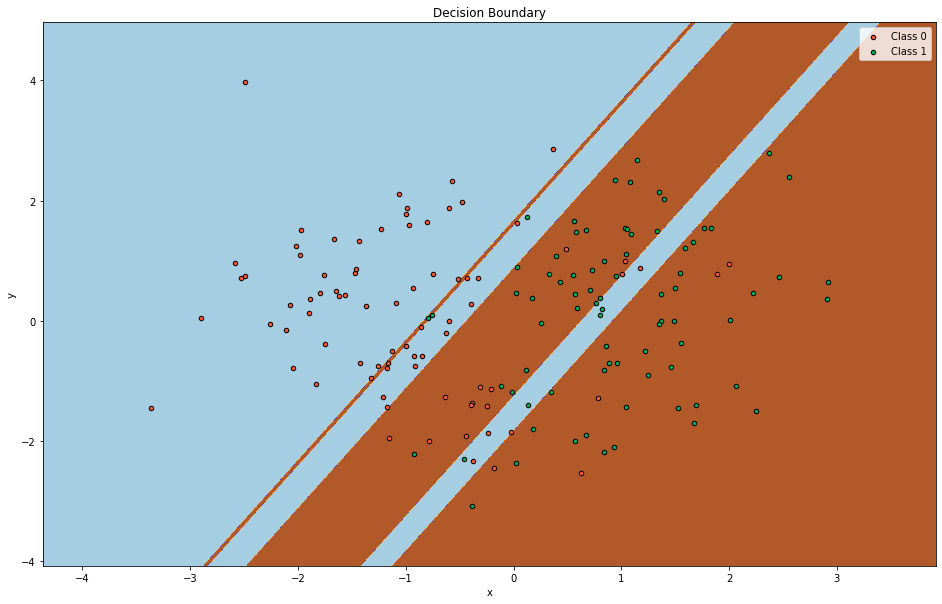

In [55]:
fig = plt.figure()
fig.set_size_inches(16, 10) 

### Вычислим границы признакового пространства

pixel_step = 0.01

x1_min, x1_max = X_train.values[:, 0].min() - 1, X_train.values[:, 0].max() + 1
x2_min, x2_max = X_train.values[:, 1].min() - 1, X_train.values[:, 1].max() + 1

### Генерим много-много точек на плоскости

xx1, xx2 = np.meshgrid(
    np.arange(x1_min, x1_max, pixel_step),
    np.arange(x2_min, x2_max, pixel_step)
)

### Для каждой точки даем прогноз, чтобы покрыть поверхности

Z = pipe.predict(pd.DataFrame(np.c_[xx1.ravel(), xx2.ravel()], columns=["x1", "x2"]))
Z = Z.reshape(xx1.shape)

# Заполняем пространство

cs = plt.contourf(xx1, xx2, Z, cmap=plt.cm.Paired)

plt.axis("tight")

### Рисуем точечки и обученные области

for i, n, c in zip(range(2), pipe.classes_, ["#FF5533", "#00B050"]):
    idx = np.where(y_train == i)
    plt.scatter(
        X_train.values[idx, 0],
        X_train.values[idx, 1],
        c=c,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
    
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.legend(loc="upper right")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Decision Boundary")

plt.show()